In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('..')
from tqdm import tqdm
import pickle
from joblib import Parallel, delayed

import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import matplotlib as mpl
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV
from catboost import CatBoostClassifier
from sbi.simulators.simutils import tqdm_joblib

from common.test_statistic import BayesFactor
from common.calibration import prepare_calibration_set, estimate_rejection_probs, optimal_cutoffs
from common.utils import select_n_jobs
from lf2i.confidence_regions.neyman_inversion import compute_confidence_regions

## Data

### Quick EDA and split

In [6]:
data = pd.read_csv('./data/sim_results.csv')
data

LYZ  GNLY  HLA-DRA  NKG7  CD74  S100A9  CCL5  S100A8  JUND  IGKC  ...  \
0        1     0        1     1     2       0     5       0     2     0  ...   
1        2     1        2     0     6       0     0       0     0     0  ...   
2        0     0        0     0     3       2     3       0     0     0  ...   
3        0     0        0     0     0       1     0       1     0     0  ...   
4        0     0        0     1     0       0     1       0     0     0  ...   
...    ...   ...      ...   ...   ...     ...   ...     ...   ...   ...  ...   
79995    0     6        0     5     0       1    13       0     0     0  ...   
79996    0     0        0    19     1       0     5       0     0     0  ...   
79997    0    10        1    23     3       0    11       1     0     0  ...   
79998    0     1        0    46     2       0    31       0     0     0  ...   
79999    0     1        0     4     3       0     1       0     0     0  ...   

       FCGR3A  GRN  CEBPD  SERPINA1  MAFB  ZEB2  NPC2  CD8B         cell_type  \
0           0    1      1         0     0     1     0     3       CD4+ T cell   
1           0    2      0         0     0     0     1     0       CD4+ T cell   
2           0    0      1         0     0     1     0     0       CD4+ T cell   
3           0    0      0         0     0     0     2     1       CD4+ T cell   
4           0    0      0         0     0     1     0     1       CD4+ T cell   
...       ...  ...    ...       ...   ...   ...   ...   ...               ...   
79995       0    0      0         0     0     1     0     1  Cytotoxic T cell   
79996       1    0      0         0     0     0     0     0  Cytotoxic T cell   
79997       1    0      0         0     0     0     1     0  Cytotoxic T cell   
79998       0    0      1         0     0     0     1     1  Cytotoxic T cell   
79999       0    0      0         0     0     2     0     5  Cytotoxic T cell   

       run_name  
0       V2 only  
1       V2 only  
2       V2 only  
3       V2 only  
4       V2 only  
...         ...  
79995    Low V3  
79996    Low V3  
79997    Low V3  
79998    Low V3  
79999    Low V3  

[80000 rows x 102 columns]

In [4]:
data.loc[data.cell_type == 'CD4+ T cell', 'cell_type'] = 1
data.loc[data.cell_type == 'Cytotoxic T cell', 'cell_type'] = 0

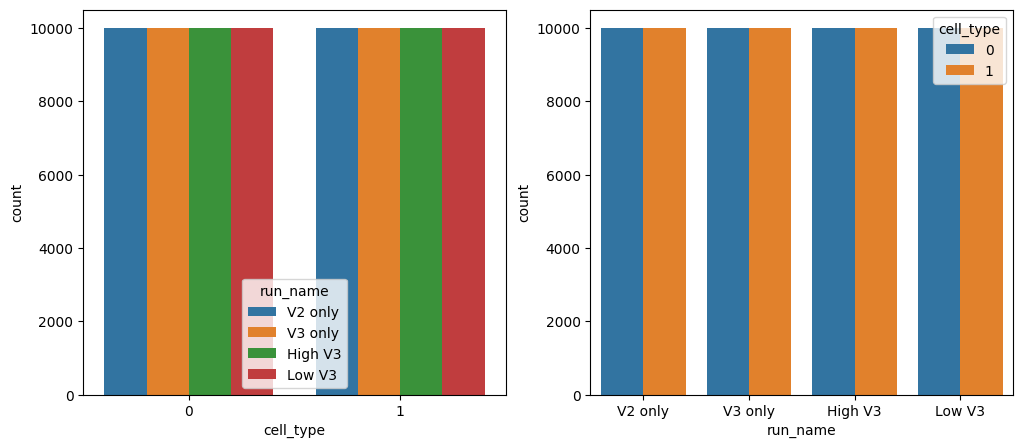

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(data=data, x='cell_type', hue='run_name', ax=ax[0])
sns.countplot(data=data, x='run_name', hue='cell_type', ax=ax[1])
plt.show()

In [7]:
TRAIN_SET_PROP, CALIB_SET_PROP, TEST_SET_PROP = 0.6, 0.35, 0.05
split_idx = np.random.choice(range(len(data)), size=len(data), replace=False)

shuffled_data = data.iloc[split_idx, :]

train_set = shuffled_data.iloc[:int(TRAIN_SET_PROP*len(shuffled_data)), :].reset_index(drop=True)
calibration_set = shuffled_data.iloc[int(TRAIN_SET_PROP*len(shuffled_data)):int((TRAIN_SET_PROP+CALIB_SET_PROP)*len(shuffled_data)), :].reset_index(drop=True)
test_set = shuffled_data.iloc[int((TRAIN_SET_PROP+CALIB_SET_PROP)*len(shuffled_data)):, :].reset_index(drop=True)
train_set.shape, calibration_set.shape, test_set.shape, len(train_set)+len(calibration_set)+len(test_set)

((48000, 102), (28000, 102), (4000, 102), 80000)

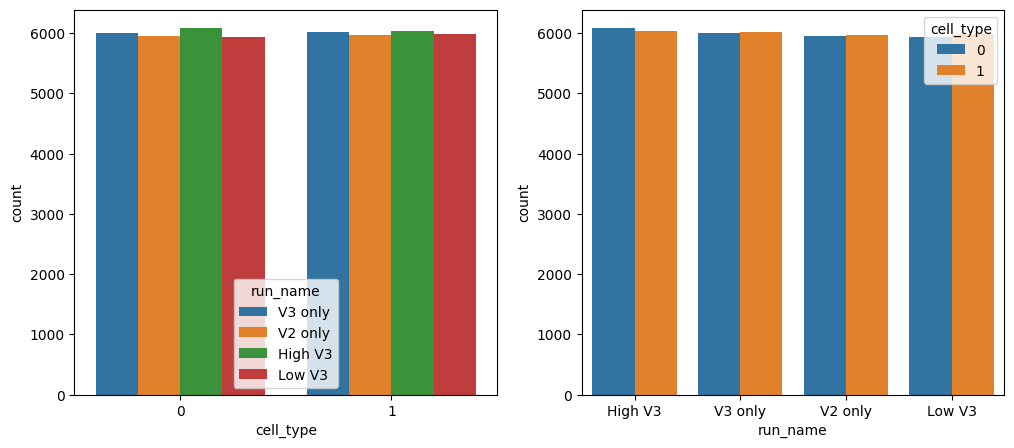

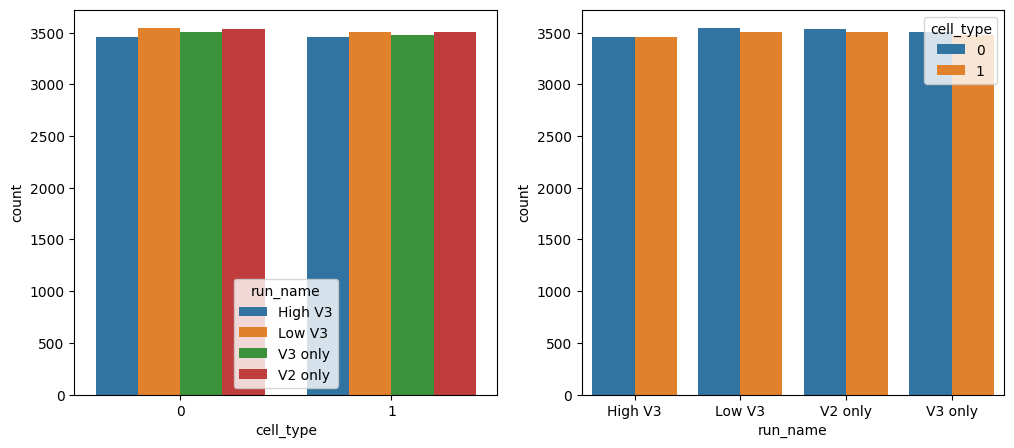

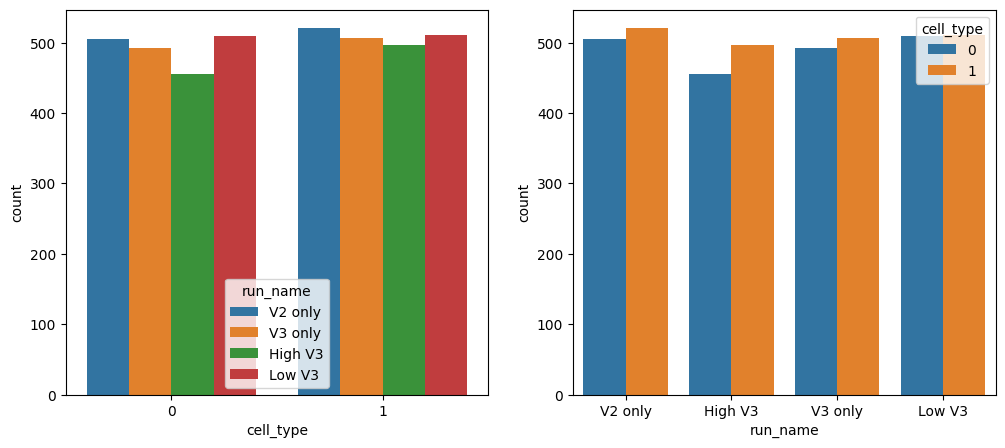

In [8]:
for d in [train_set, calibration_set, test_set]:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    sns.countplot(data=d, x='cell_type', hue='run_name', ax=ax[0])
    sns.countplot(data=d, x='run_name', hue='cell_type', ax=ax[1])
    plt.show()

In [9]:
with open('./data/split_data.pkl', 'wb') as f:
    pickle.dump({'train_set': train_set, 'calibration_set': calibration_set, 'test_set': test_set}, f)

## Classifier

In [5]:
X_train, y_train = train_set.drop(columns=['run_name', 'cell_type']).values, train_set.loc[:, 'cell_type'].values.astype(int)
X_train.shape, y_train.shape

((48000, 100), (48000,))

### GB

In [6]:
cat_gb = RandomizedSearchCV(
    estimator=CatBoostClassifier(
        loss_function='CrossEntropy',
        silent=True
    ),
    param_distributions={'iterations': [100, 300, 500, 700, 1000], 'depth': [1, 3, 5, 7, 10]},
    n_iter=25,
    n_jobs=select_n_jobs(20),
    refit=True,
    cv=5,
    verbose=1
)
cat_gb.fit(X=X_train, y=y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


/home/azureuser/miniconda3/envs/systematics-pps/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f0ddefa8650>,
                   n_iter=25, n_jobs=20,
                   param_distributions={'depth': [1, 3, 5, 7, 10],
                                        'iterations': [100, 300, 500, 700,
                                                       1000]},
                   verbose=1)

In [7]:
cat_gb.best_params_

{'iterations': 1000, 'depth': 7}

In [9]:
with open('./results/pickles/catgb_clf.pkl', 'wb') as f:
    pickle.dump(cat_gb, f)

## Test Statistic

In [10]:
bayes_factor = BayesFactor(
    poi_dim=1,
    estimator=cat_gb
)

In [11]:
bf_train = bayes_factor.evaluate(samples=X_train)
bf_train.shape

(48000, 2)

In [12]:
fig, ax = plt.subplots(2, 4, figsize=(12, 5))

for null in [0, 1]:
    sns.kdeplot(bf_train[(train_set.run_name == 'V2 only') & (y_train == null), null], ax=ax[null, 0], label=f'null={null}, true={null}')
    sns.kdeplot(bf_train[(train_set.run_name == 'V2 only') & (y_train == (1-null)), null], ax=ax[null, 0], label=f'null={null}, true={(1-null)}')
    ax[null, 0].set_title('V2 only')
    ax[null, 0].legend()
    ax[null, 0].set_xlabel(r'$\log\tau_{y_{null}}(\mathbf{x})$')

    sns.kdeplot(bf_train[(train_set.run_name == 'V3 only') & (y_train == null), null], ax=ax[null, 1], label=f'null={null}, true={null}')
    sns.kdeplot(bf_train[(train_set.run_name == 'V3 only') & (y_train == (1-null)), null], ax=ax[null, 1], label=f'null={null}, true={(1-null)}')
    ax[null, 1].set_title('V3 only')
    ax[null, 1].legend()
    ax[null, 1].set_xlabel(r'$\log\tau_{y_{null}}(\mathbf{x})$')

    sns.kdeplot(bf_train[(train_set.run_name == 'Low V3') & (y_train == null), null], ax=ax[null, 2], label=f'null={null}, true={null}')
    sns.kdeplot(bf_train[(train_set.run_name == 'Low V3') & (y_train == (1-null)), null], ax=ax[null, 2], label=f'null={null}, true={(1-null)}')
    ax[null, 2].set_title('Low V3')
    ax[null, 2].legend()
    ax[null, 2].set_xlabel(r'$\log\tau_{y_{null}}(\mathbf{x})$')

    sns.kdeplot(bf_train[(train_set.run_name == 'High V3') & (y_train == null), null], ax=ax[null, 3], label=f'null={null}, true={null}')
    sns.kdeplot(bf_train[(train_set.run_name == 'High V3') & (y_train == (1-null)), null], ax=ax[null, 3], label=f'null={null}, true={(1-null)}')
    ax[null, 3].set_title('High V3')
    ax[null, 3].legend()
    ax[null, 3].set_xlabel(r'$\log\tau_{y_{null}}(\mathbf{x})$')
    
plt.suptitle(r'BF within $\nu$ groups, for different null/y combinations'+f'\n0: "Cytotoxic T cell", 1: "CD4+ T cell"', y=1)
plt.tight_layout()
plt.show()

## Calibration

### Estimate Rejection Probs

In [13]:
X_calib, nu_calib, y_calib = calibration_set.drop(columns=['run_name', 'cell_type']).values, calibration_set.loc[:, 'run_name'].values, calibration_set.loc[:, 'cell_type'].values.astype(int)
X_calib.shape, nu_calib.shape, y_calib.shape

((28000, 100), (28000,), (28000,))

In [14]:
bf_calib = bayes_factor.evaluate(samples=X_calib)
bf_calib.shape

(28000, 2)

In [16]:
calib_inputs, rejection_indicators = prepare_calibration_set(
    test_statistics=bf_calib,
    poi=y_calib,
    nuisance=nu_calib,
    control='power',
    cutoff_sampling='empirical-cdf',
    num_cutoffs=50,
    shuffle=True,
    return_pd=True
)
calib_inputs.shape, rejection_indicators.shape

((1400000, 4), (1400000,))

In [17]:
with open('./data/augment_calib_data.pkl', 'wb') as f:
    pickle.dump({'calib_inputs': calib_inputs, 'rejection_indicators': rejection_indicators}, f)

In [18]:
reject_probs_model = estimate_rejection_probs(
    inputs=calib_inputs,
    rejection_indicators=rejection_indicators,
    method='gb',
    hyperparams={'iterations': [100, 300, 500, 700, 1000], 'depth': [1, 3, 5, 7, 10]},
    n_jobs=select_n_jobs(20),
    cat_features_idxs=[1, 2, 3],
    n_iter=25
)

Fitting 5 folds for each of 25 candidates, totalling 125 fits


/home/azureuser/miniconda3/envs/systematics-pps/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [19]:
reject_probs_model.best_params_

{'iterations': 300, 'depth': 5}

In [20]:
calibrated_reject_probs_model = CalibratedClassifierCV(
    estimator=reject_probs_model,
    method='isotonic',
    cv='prefit'
)
calibrated_reject_probs_model.fit(X=calib_inputs, y=rejection_indicators)

CalibratedClassifierCV(cv='prefit',
                       estimator=RandomizedSearchCV(cv=5,
                                                    estimator=<catboost.core.CatBoostClassifier object at 0x7f0f90917610>,
                                                    n_iter=25, n_jobs=50,
                                                    param_distributions={'depth': [1,
                                                                                   3,
                                                                                   5,
                                                                                   7,
                                                                                   10],
                                                                         'iterations': [100,
                                                                                        300,
                                                                                        500,
                                                                                        700,
                                                                                        1000]},
                                                    verbose=1),
                       method='isotonic')

In [21]:
with open('./results/pickles/reject_probs_model.pkl', 'wb') as f:
    pickle.dump(reject_probs_model, f)
with open('./results/pickles/calibrated_reject_probs_model.pkl', 'wb') as f:
    pickle.dump(calibrated_reject_probs_model, f)

### Checks

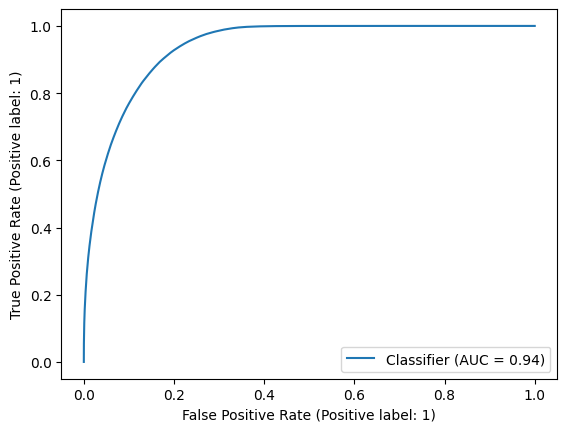

In [22]:
RocCurveDisplay.from_predictions(
    y_true=rejection_indicators,
    y_pred=calibrated_reject_probs_model.predict_proba(X=calib_inputs)[:, 1]
)

In [23]:
calib_inputs.iloc[:, :]

c      null        mu      nu0
0       -3.206123  negative  negative  High V3
1        9.799071  positive  positive  V3 only
2        3.773036  negative  negative   Low V3
3       -8.155156  negative  negative  High V3
4       -5.499647  positive  positive   Low V3
...           ...       ...       ...      ...
1399995 -5.862965  negative  negative  V2 only
1399996 -6.115857  positive  positive  V2 only
1399997 -5.448086  negative  negative  V2 only
1399998  7.342040  negative  negative  V2 only
1399999  7.449288  negative  negative  V2 only

[1400000 rows x 4 columns]

In [24]:
grid_size = 100_000
c_grid = np.linspace(*calib_inputs.loc[:, ['c']].agg(['min', 'max']).values.reshape(-1, ), grid_size)

# Power for null = mu = 0
calib_set_idx = 0
temp_inp = pd.DataFrame({
    'c': c_grid,
    'null': np.repeat(calib_inputs.null.values[calib_set_idx], repeats=grid_size), 
    'mu': np.repeat(calib_inputs.mu.values[calib_set_idx], repeats=grid_size), 
    'nu0': np.repeat(calib_inputs.nu0.values[calib_set_idx], repeats=grid_size)
})
plt.scatter(
    x=c_grid, y=calibrated_reject_probs_model.predict_proba(X=temp_inp)[:, 1],
    label=r'Power for $\mu_0 = \mu = 0$', s=10
)

# Power for null = mu = 1
calib_set_idx = 1
temp_inp = pd.DataFrame({
    'c': c_grid,
    'null': np.repeat(calib_inputs.null.values[calib_set_idx], repeats=grid_size), 
    'mu': np.repeat(calib_inputs.mu.values[calib_set_idx], repeats=grid_size), 
    'nu0': np.repeat(calib_inputs.nu0.values[calib_set_idx], repeats=grid_size)
})
plt.scatter(
    x=c_grid, y=calibrated_reject_probs_model.predict_proba(X=temp_inp)[:, 1],
    label=r'Power for $\mu_0 = \mu = 1$', s=10
)

plt.xlabel(r'$C$')
plt.ylabel(r'$\mathbb{P}_{\mu, \nu}(\tau_{\mu_0} \leq C)$', rotation=0, labelpad=20)
plt.legend()
plt.title('Estimated rejection probabilities as a function of cutoff')
plt.show()

## Confidence Sets

In [25]:
# nu test not used. mu test only to check results
X_test, nu_test, y_test = test_set.drop(columns=['run_name', 'cell_type']).values, test_set.loc[:, 'run_name'].values, test_set.loc[:, 'cell_type'].values.astype(int)
X_test.shape, nu_test.shape, y_test.shape

((4000, 100), (4000,), (4000,))

In [26]:
min_c_neg, max_c_neg = calib_inputs.loc[(calib_inputs.null == 'negative') & (calib_inputs.mu == 'negative'), :].agg(['min', 'max']).loc[:, 'c'].values
min_c_pos, max_c_pos = calib_inputs.loc[(calib_inputs.null == 'positive') & (calib_inputs.mu == 'positive'), :].agg(['min', 'max']).loc[:, 'c'].values
(min_c_neg, max_c_neg), (min_c_pos, max_c_pos)

((-16.851345953474368, 15.046704884826488),
 (-16.851345953474368, 15.046704884826488))

In [27]:
alpha_grid = np.array([0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1, 0.05, 0.01])

In [28]:
def do_one(alpha_value):
    opt_c = optimal_cutoffs(
        alpha=alpha_value,
        rejection_probs_model=calibrated_reject_probs_model,
        cutoffs_bounds=[(min_c_neg, max_c_neg), (min_c_pos, max_c_pos)],
        control='power',
        opt_method='enumerate',
        max_range_expand=100,
        discrete_nuisances=['V2 only', 'V3 only', 'Low V3', 'High V3'],
        verbose=True
    )
    return opt_c, compute_confidence_regions(
        test_statistic=bayes_factor.evaluate(samples=X_test),
        critical_values=opt_c,
        parameter_grid=np.array([0, 1]),
        acceptance_region=bayes_factor.acceptance_region,
        poi_dim=bayes_factor.poi_dim
    )
with tqdm_joblib(tqdm(alpha_grid, total=len(alpha_grid))) as _:
    opt_cutoffs, confidence_sets = tuple(zip(*Parallel(n_jobs=-2)(delayed(do_one)(alpha) for alpha in alpha_grid)))

  0%|          | 0/11 [00:00<?, ?it/s]

100%|██████████| 11/11 [00:08<00:00,  1.29it/s]


In [29]:
with open('./results/pickles/cutoffs_and_confSets.pkl', 'wb') as f:
    pickle.dump({'opt_cutoffs': opt_cutoffs, 'conf_sets': confidence_sets}, f)

In [30]:
set_clf_outputs = []
for idx_alpha, cs_at_alpha in tqdm(enumerate(confidence_sets)):
    # 0, 1, -1 (both), -2 (empty)
    set_clf_outputs_alpha = []
    for idx, cs in enumerate(cs_at_alpha):
        cs = cs.reshape(-1 )
        if len(cs) == 0:
            set_clf_outputs_alpha.append(-2)
        elif len(cs) == 1:
            set_clf_outputs_alpha.append(cs.item())
        elif len(cs) == 2:
            set_clf_outputs_alpha.append(-1)
        else:
            print(cs, flush=True)
            raise ValueError("There's something wrong")
    set_clf_outputs.append(set_clf_outputs_alpha)
d = {'true': y_test}
d.update({f'setClf_alpha{alpha_grid[i]:.3f}': o for i, o in enumerate(set_clf_outputs)})
results_df = pd.DataFrame(d)
results_df

11it [00:00, 395.98it/s]

true  setClf_alpha0.500  setClf_alpha0.450  setClf_alpha0.400  \
0        0                 -2                 -2                 -2   
1        1                 -2                 -2                 -2   
2        0                  0                  0                  0   
3        1                  1                  1                  1   
4        0                 -2                 -2                  0   
...    ...                ...                ...                ...   
3995     0                  0                  0                  0   
3996     0                 -2                 -2                 -2   
3997     1                  1                  1                  1   
3998     1                 -2                  1                  1   
3999     1                 -2                 -2                 -2   

      setClf_alpha0.350  setClf_alpha0.300  setClf_alpha0.250  \
0                    -2                 -2                 -2   
1                    -2                  1                  1   
2                     0                  0                  0   
3                     1                  1                  1   
4                     0                  0                  0   
...                 ...                ...                ...   
3995                  0                  0                  0   
3996                 -2                  0                  0   
3997                  1                  1                  1   
3998                  1                  1                  1   
3999                 -2                 -2                 -2   

      setClf_alpha0.200  setClf_alpha0.150  setClf_alpha0.100  \
0                    -2                 -2                 -2   
1                     1                  1                  1   
2                     0                  0                  0   
3                     1                  1                  1   
4                     0                  0                  0   
...                 ...                ...                ...   
3995                  0                  0                  0   
3996                  0                  0                  0   
3997                  1                  1                  1   
3998                  1                  1                  1   
3999                 -2                  1                  1   

      setClf_alpha0.050  setClf_alpha0.010  
0                    -2                 -1  
1                     1                  1  
2                     0                  0  
3                     1                  1  
4                     0                  0  
...                 ...                ...  
3995                  0                  0  
3996                  0                  0  
3997                  1                  1  
3998                  1                  1  
3999                  1                  1  

[4000 rows x 12 columns]

In [31]:
with open('./results/pickles/setClf_alpha.pkl', 'wb') as f:
    pickle.dump(results_df, f)